In [15]:
import os
import glob
import json
import yaml
import shutil
import torch
import random
import cv2
from google.colab.patches import cv2_imshow
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split




!pip install ultralytics
from ultralytics import YOLO
import os, zipfile

In [ ]:
zip_path = "/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/멀티모달 개인과제/data/fittogether.zip"
tmp_dir  = "/content/dataset/raw_data"
train_root = '/content/dataset/train'
valid_root = '/content/dataset/valid'


# 폴더 생성
for path in [train_root, valid_root]:
  os.makedirs(f'{path}/images', exist_ok=True)
  os.makedirs(f'{path}/labels', exist_ok=True)

In [ ]:
# 3. 무거운 파일을 위한 파이썬 압축 해제 로직
if os.path.exists(zip_path):
    print(f"압축 해제 시작: {zip_path}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 압축 파일 내의 모든 파일 리스트를 가져옵니다.
        file_list = zip_ref.namelist()

        # tqdm을 사용하여 압축 해제 진행률을 시각화합니다.
        for file in tqdm(file_list, desc="Extracting"):
            try:
                zip_ref.extract(file, tmp_dir)
            except Exception as e:
                print(f"에러 발생 ({file}): {e}")
    print("압축 해제 완료!")
else:
    print("오류: 지정한 zip_path에 파일이 없습니다. 경로를 다시 확인해주세요.")


압축 해제 시작: /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/멀티모달 개인과제/data/fittogether.zip


Extracting: 100%|██████████| 22300/22300 [01:19<00:00, 281.26it/s]

압축 해제 완료!


In [ ]:
# 압축 풀린 폴더 내부 구조 확인
!ls -R /content/dataset/raw_data | head -n 20

/content/dataset/raw_data:
video_01_000036.jpg
video_01_000036.json
video_01_000037.jpg
video_01_000037.json
video_01_000038.jpg
video_01_000038.json
video_01_000039.jpg
video_01_000039.json
video_01_000041.jpg
video_01_000041.json
video_01_000042.jpg
video_01_000042.json
video_01_000043.jpg
video_01_000043.json
video_01_000044.jpg
video_01_000044.json
video_01_000045.jpg
video_01_000045.json
video_01_000046.jpg


In [ ]:
# 1. 모든 JSON/이미지 파일 경로 가져오기
all_json = glob.glob('/content/dataset/raw_data/*.json')
print(f'원본 데이터: {len(all_json)}개')

# 2. 데이터 샘플링 (30%만 사용)
sample_ratio = 0.3
random.seed(42)
sampled_json = random.sample(all_json, int(len(all_json) * sample_ratio))
print(f'샘플링된 데이터: {len(sampled_json)}개')

# 3. Train/Valid로 분할 (8:2 비율)
train_json, valid_json = train_test_split(
    sampled_json,
    test_size = 0.2,
    random_state = 42
)

train_images = [j.replace('.json', '.jpg') for j in train_json]
valid_images = [j.replace('.json', '.jpg') for j in valid_json]

print(f'학습: {len(train_images)}개, 검증: {len(valid_images)}개')

for img in tqdm(train_images, desc='Copying train images'):
    shutil.copy(img, f'{train_root}/images/')

for img in tqdm(valid_images, desc="Copying valid images"):
    shutil.copy(img, f'{valid_root}/images')


원본 데이터: 11150개
샘플링된 데이터: 3345개
학습: 2676개, 검증: 669개


Copying valid images: 100%|██████████| 669/669 [00:01<00:00, 335.20it/s]


In [ ]:
def fix_labels_labelme(json_list, target_root):
    # 클래스 매핑 (데이터셋에 맞게 수정 가능)
    # 현재 로그에는 'players'가 보이므로 0으로 설정
    class_map = {'players': 0, 'ball': 1, 'referee': 2}

    for json_path in tqdm(json_list, desc=f"Fixing {target_root.split('/')[-1]}"):
        p = Path(json_path)
        file_name = p.stem

        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        img_w = data.get('imageWidth')
        img_h = data.get('imageHeight')

        # YOLO TXT 작성
        with open(f"{target_root}/labels/{file_name}.txt", 'w') as f_txt:
            for shape in data.get('shapes', []):
                label = shape.get('label')
                class_id = class_map.get(label, 0) # 매핑 없으면 0번

                # Labelme의 points는 [[x1, y1], [x2, y2]] 구조 (대각선 두 점)
                points = shape.get('points')
                if points and len(points) == 2:
                    x1, y1 = points[0]
                    x2, y2 = points[1]

                    # 1. 실제 좌표 계산
                    abs_w = abs(x2 - x1)
                    abs_h = abs(y2 - y1)
                    center_x = (x1 + x2) / 2
                    center_y = (y1 + y2) / 2

                    # 2. 0~1 사이로 정규화
                    norm_x = center_x / img_w
                    norm_y = center_y / img_h
                    norm_w = abs_w / img_w
                    norm_h = abs_h / img_h

                    f_txt.write(f"{class_id} {norm_x:.6f} {norm_y:.6f} {norm_w:.6f} {norm_h:.6f}\n")

# 전처리 다시 실행
fix_labels_labelme(train_json, train_root)
fix_labels_labelme(valid_json, valid_root)

Fixing valid: 100%|██████████| 669/669 [00:00<00:00, 1563.99it/s]


In [ ]:
# 라벨 파일 하나 출력해보기
import glob
label_files = glob.glob('/content/dataset/train/labels/*.txt')
if label_files:
    print(f"파일 경로: {label_files[0]}")
    with open(label_files[0], 'r') as f:
        print("내용:", f.read())
else:
    print("라벨 파일이 생성되지 않았습니다.")

파일 경로: /content/dataset/train/labels/video_10_000168.txt
내용: 0 0.508008 0.430620 0.008000 0.040355
0 0.116012 0.787308 0.012773 0.072320
0 0.032508 0.585301 0.015279 0.063498
0 0.062471 0.568839 0.009988 0.058324
0 0.094715 0.495463 0.019918 0.052815
0 0.081840 0.425062 0.015894 0.035767



In [ ]:
import json
import glob

# JSON 파일 하나 선택
json_sample = glob.glob('/content/dataset/raw_data/*.json')[0]

with open(json_sample, 'r', encoding='utf-8') as f:
    sample_data = json.load(f)

# JSON의 키(Key) 목록과 전체 내용 출력
print("JSON Keys:", sample_data.keys())
print("-" * 30)
print(json.dumps(sample_data, indent=2, ensure_ascii=False)[:2000]) # 앞부분 2000자만 출력

JSON Keys: dict_keys(['version', 'flags', 'shapes', 'imagePath', 'imageWidth', 'imageHeight', 'imageData'])
------------------------------
{
  "version": "4.5.6",
  "flags": {},
  "shapes": [
    {
      "label": "players",
      "points": [
        [
          1696.8749610756956,
          1033.1130854838812
        ],
        [
          1743.430603360715,
          1118.06863709888
        ]
      ],
      "shape_type": "rectangle",
      "labels": [],
      "id": 14898591,
      "flags": {}
    },
    {
      "label": "players",
      "points": [
        [
          3164.9068929828736,
          1213.5586771141386
        ],
        [
          3199.908580248253,
          1328.758405104077
        ]
      ],
      "shape_type": "rectangle",
      "labels": [],
      "id": 14898592,
      "flags": {}
    },
    {
      "label": "players",
      "points": [
        [
          3246.8040447397325,
          1110.59254855676
        ],
        [
          3291.660575992452,
          

In [17]:
data_yaml = {
    'train': train_root + '/images',
    'val': valid_root + '/images',
    'nc': 2,
    'names': ['Player', 'Ball']
}

with open('/content/dataset/soccer.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print('YAML 파일 재생성 완료!')

YAML 파일 재생성 완료!


In [ ]:
# [실험 1] YOLOv8n(가장 가벼운 모델)으로 학습
model_n = YOLO('yolov8n.pt')
model_n.train(
    data='/content/dataset/soccer.yaml',
    epochs=30,
    imgsz=640,
    device=0,
    name='soccer_n_model',
    exist_ok=True
)

# [실험 2] YOLOv8s(조금 더 무겁지만 정확한 모델)으로 학습
model_s = YOLO('yolov8s.pt')
model_s.train(
    data='/content/dataset/soccer.yaml',
    epochs=30,
    imgsz=640,
    device=0,
    name='soccer_s_model',
    exist_ok=True
)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/soccer.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=soccer_n_model, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, p

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7848426680b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

--- 실험 2 (Small 모델) 학습 결과 ---


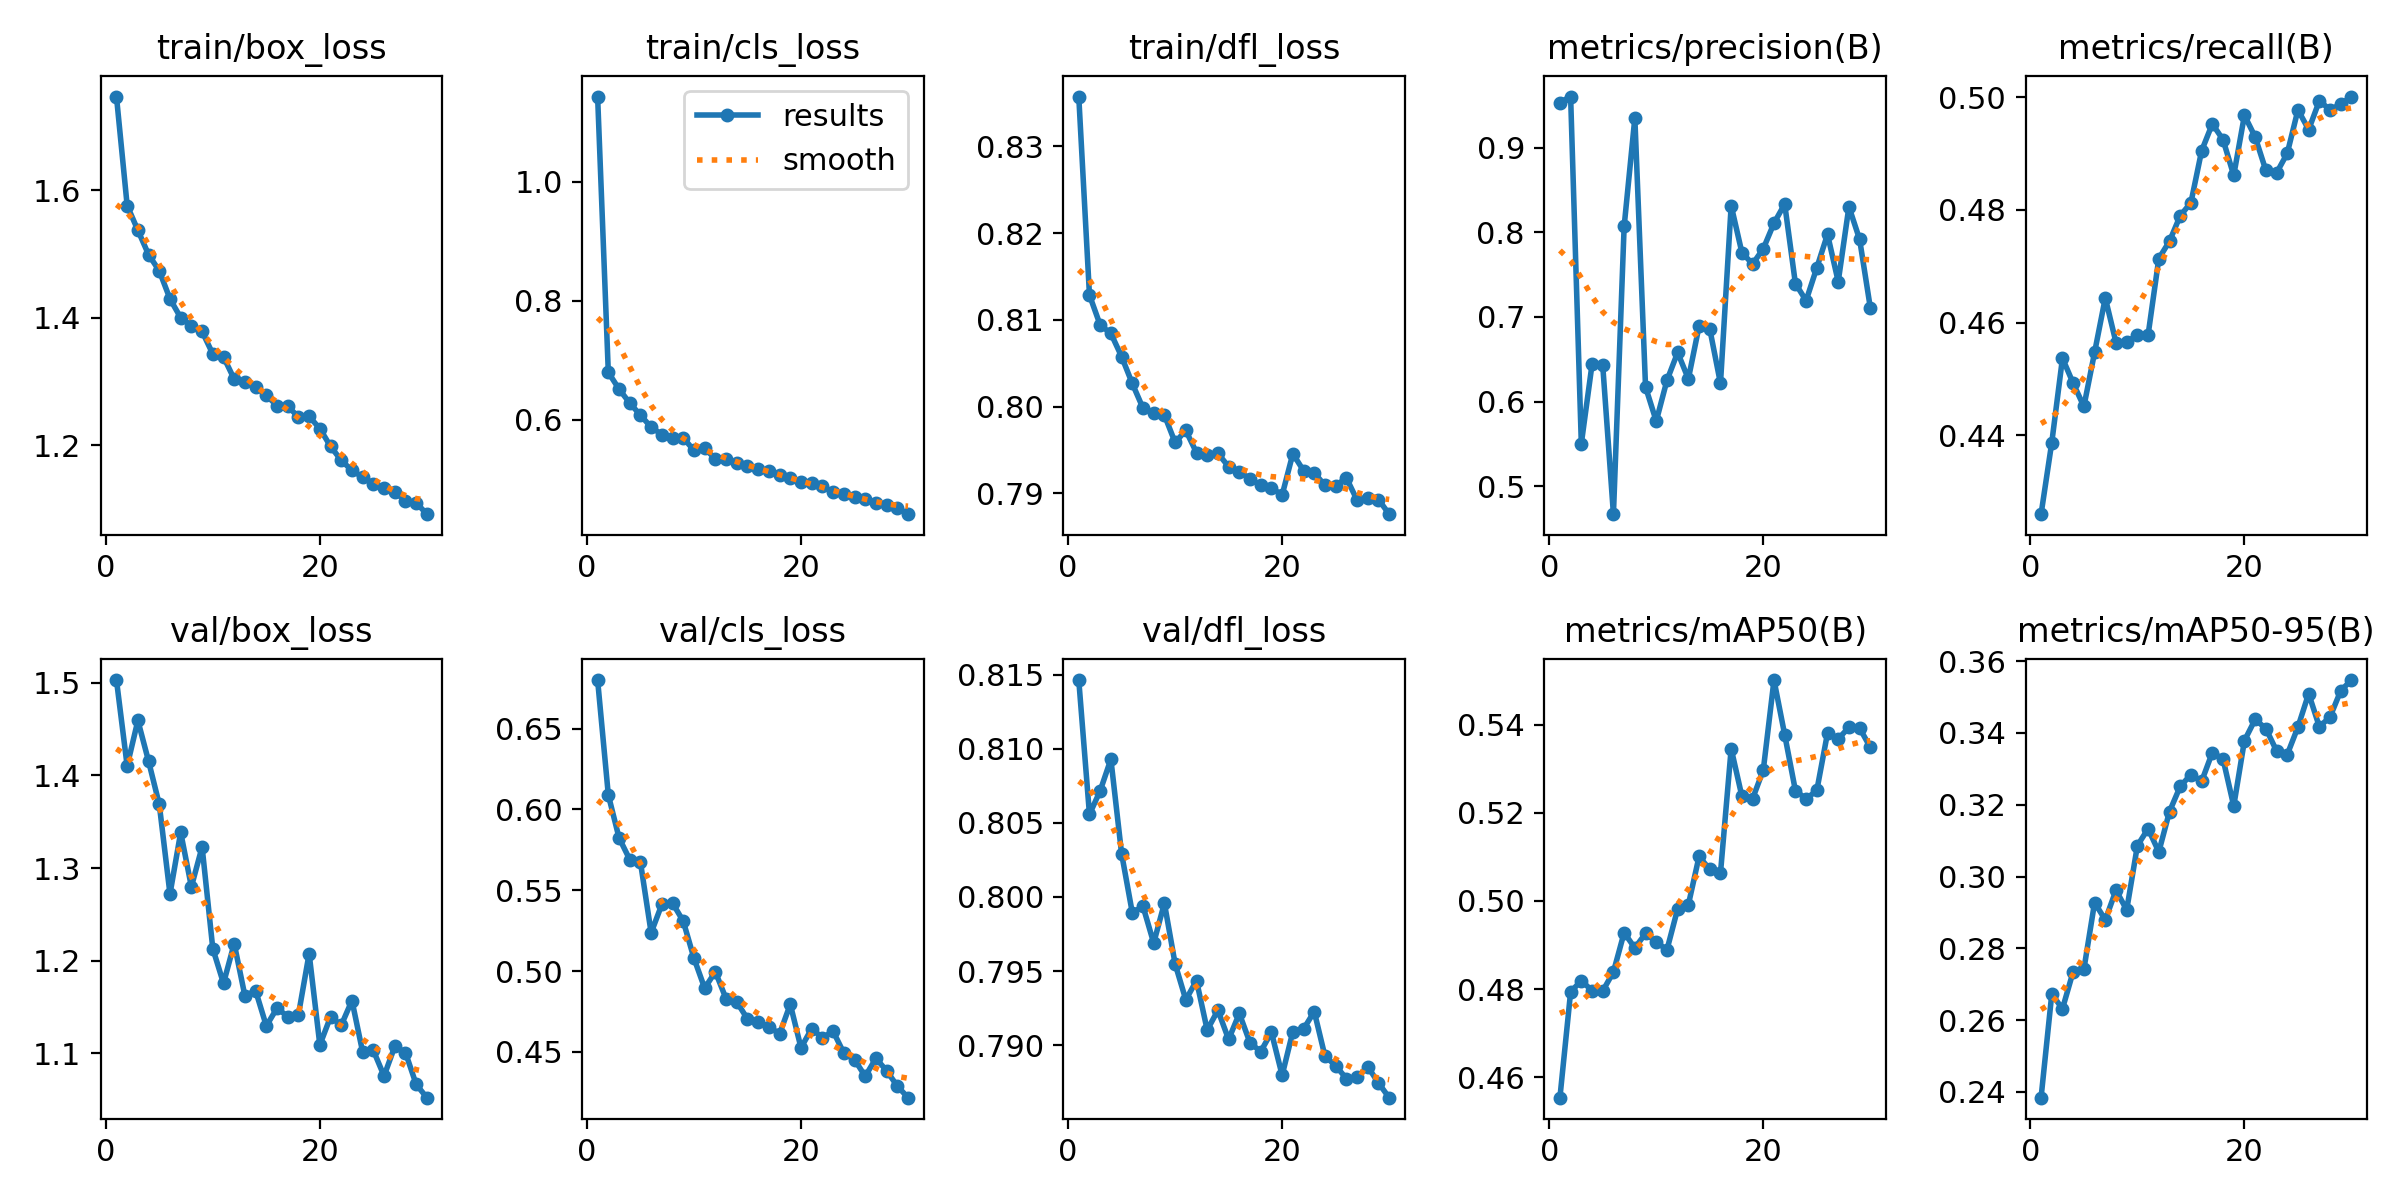

In [ ]:
# 1. 학습 결과 시각화 확인 (둘 중 성능이 더 좋은 모델의 결과를 출력)
from IPython.display import Image
print("--- 실험 2 (Small 모델) 학습 결과 ---")
Image(filename='/content/runs/detect/soccer_s_model/results.png')

# 2. 성능 비교 코멘트 (예시)
# "실험 결과, Nano 모델보다 Small 모델의 mAP50 수치가 약 0.05 높게 나타났습니다.
# 하지만 학습 속도는 Nano 모델이 약 1.5배 빨랐습니다."

In [18]:
# 학습된 모델 로드 (Best 모델 사용)
model = YOLO('/content/runs/detect/soccer_s_model/weights/best.pt')

# 검증 이미지 목록 가져오기
valid_images = glob.glob('/content/dataset/valid/images/*.jpg')

# 랜덤으로 9장 선택
random.seed(42)
sample_images = random.sample(valid_images, 9)

# 결과 저장 폴더 생성
output_dir = '/content/sample_predictions'
os.makedirs(output_dir, exist_ok=True)

print(f"📸 {len(sample_images)}장의 이미지에 대해 탐지 시작...\n")

# 각 이미지에 대해 예측
for idx, img_path in enumerate(sample_images, 1):
    # 예측 실행
    results = model(img_path, conf=0.25)  # confidence threshold

    # 결과 이미지 저장
    result_img = results[0].plot()  # 바운딩 박스가 그려진 이미지
    output_path = f'{output_dir}/prediction_{idx}.jpg'
    cv2.imwrite(output_path, result_img)

    # 탐지된 객체 정보 출력
    detections = results[0].boxes
    print(f"[{idx}] {Path(img_path).name}")
    print(f"   탐지된 객체 수: {len(detections)}")

    # 클래스별 카운트
    classes = detections.cls.cpu().numpy()
    player_count = (classes == 0).sum()
    ball_count = (classes == 1).sum()
    print(f"   - Player: {player_count}개, Ball: {ball_count}개\n")

# 결과 이미지 표시
print("\n✅ 탐지 결과 이미지:")
for idx in range(1, 10):
    img = cv2.imread(f'{output_dir}/prediction_{idx}.jpg')
    print(f"\n--- 이미지 {idx} ---")
    cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.